## 1. Set-up

In [32]:
# 패키지(라이브러리)들을 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [30]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [31]:
# 데이터 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [33]:
# val 개수가 적어 train에서 일부 가져와 train : val를 80:20으로 분할
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [34]:
# 파일 경로 중 폴더명을 통해 구분이 가능함을 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [35]:
# 정상 이미지와 폐렴 이미지의 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [36]:
# tf.data 인스턴스 생성 - tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 준다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [37]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [38]:
# 파일 경로의 끝에서 두번째 부분(파일의 상위 폴더명)을 통해 양성과 음성을 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [39]:
# 이미지 데이터에서 사이즈를 통일 및 GPU 메모리의 효율적 사용을 위해 크기 줄이기
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [40]:
# train 데이터 셋과 validation 데이터 셋 생성
# num_parallel_calls 파라미터에 AUTOTUNE변수를 할당하면 더욱 빠르게 데이터를 처리 가능
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
# 이미지 리사이즈 및 라벨링 여부 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [42]:
# test 데이터셋 생성 및 갯수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [43]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## 3. 데이터 시각화

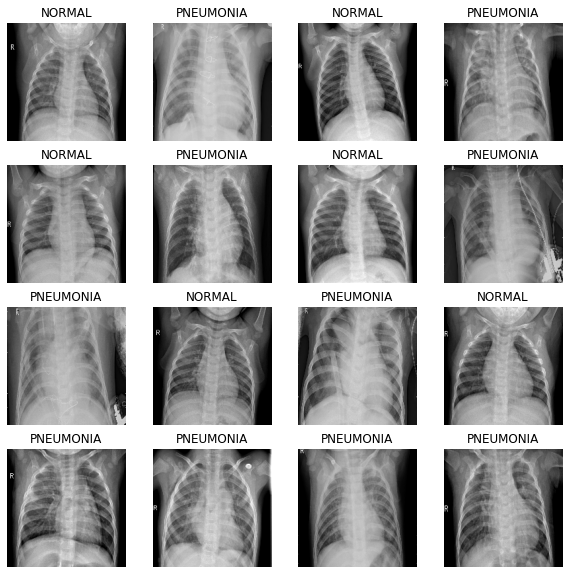

In [44]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [45]:
# Convolution block 생성
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [46]:
# Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [47]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

In [48]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [49]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 156s 376ms/step - loss: 0.3987 - accuracy: 0.8190 - precision: 0.9558 - recall: 0.7934 - val_loss: 0.8125 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 99s 379ms/step - loss: 0.2373 - accuracy: 0.9104 - precision: 0.9704 - recall: 0.9073 - val_loss: 1.1954 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 99s 380ms/step - loss: 0.1846 - accuracy: 0.9279 - precision: 0.9782 - recall: 0.9237 - val_loss: 0.3677 - val_accuracy: 0.8337 - val_precision: 0.8152 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 102s 390ms/step - loss: 0.1705 - accuracy: 0.9399 - precision: 0.9808 - recall: 0.9376 - val_loss: 0.1082 - val_accuracy: 0.9587 - val_precision: 0.9931 - val_recall: 0.9501
Epoch 5/10
261/261 [==============================] - 105s 403ms/step - loss: 0.1675 - acc

## 7. 결과 확인

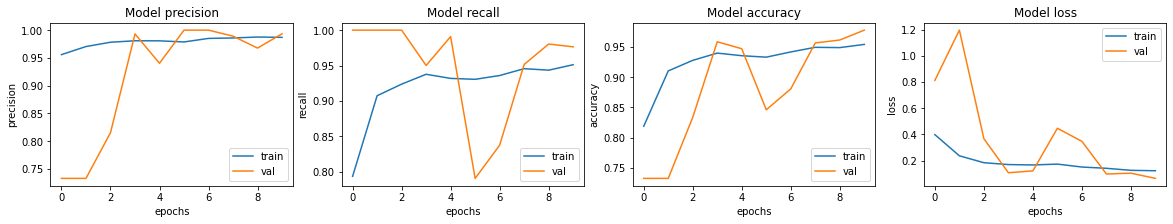

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 124ms/step - loss: 0.7945 - accuracy: 0.7660 - precision: 0.7337 - recall: 0.9821
Loss: 0.7944526672363281,
Accuracy: 0.7660256624221802,
Precision: 0.7337164878845215,
Recall: 0.9820512533187866


## ResNet 모델 구현

In [76]:
# 모델을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model # 모델 시각화

In [77]:
def residual_module(input_layer, n_filters):  
    merge_input = input_layer

# if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
    # Conv2D layer
    conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    # Conv2D layer
    conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
    
  # Add를 통해서 skip connection을 구현하는 부분
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)
 
    return out_layer

In [80]:
# 모델 구성
def build_resnet_model(input_shape, num_classes):
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 여기에서 ResNet 블록을 반복해서 추가
    for _ in range(3):  # 예: 3개의 ResNet 블록
        x = residual_module(x, 64)

    for _ in range(4):  # 예: 4개의 ResNet 블록
        x = residual_module(x, 128)

    for _ in range(6):  # 예: 6개의 ResNet 블록
        x = residual_module(x, 256)

    for _ in range(3):  # 예: 3개의 ResNet 블록
        x = residual_module(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(input_layer, output_layer)
    return model

In [81]:
# 모델 생성
input_shape = (224, 224, 3)  # 입력 이미지 크기와 채널 수에 맞게 수정
num_classes = 2  # 정상(0) 및 폐암(1) 두 개의 클래스
model = build_resnet_model(input_shape, num_classes)

In [82]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
# 모델 요약 정보 출력
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 112, 112, 64) 256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

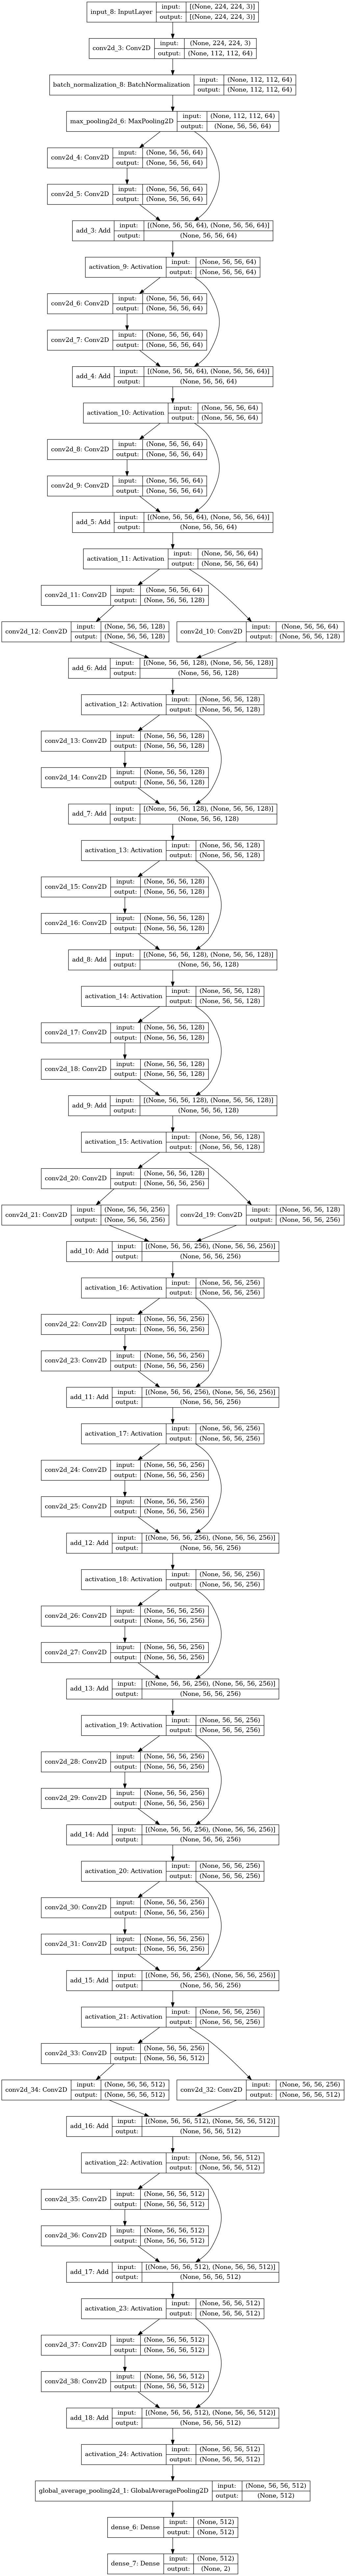

In [84]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [85]:
# 데이터 로드 및 전처리
data_dir = "/aiffel/aiffel/chest_xray/data/train/"
train_data_dir = "/path/to/train/data_directory"
test_data_dir = "/path/to/test/data_directory"
input_shape = (224, 224)  # 입력 이미지 크기
batch_size = 32
epochs = 10

In [86]:
# 데이터 증강 및 제너레이터 설정
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20%를 검증 데이터로 사용
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [87]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10
130/130 [==============================] - 203s 1s/step - loss: 36.3836 - accuracy: 0.7385 - val_loss: 0.5737 - val_accuracy: 0.7432
Epoch 2/10
130/130 [==============================] - 184s 1s/step - loss: 0.5713 - accuracy: 0.7428 - val_loss: 0.5791 - val_accuracy: 0.7402
Epoch 3/10
130/130 [==============================] - 185s 1s/step - loss: 0.5760 - accuracy: 0.7406 - val_loss: 0.5706 - val_accuracy: 0.7422
Epoch 4/10
130/130 [==============================] - 183s 1s/step - loss: 0.5884 - accuracy: 0.7397 - val_loss: 0.5747 - val_accuracy: 0.7412
Epoch 5/10
130/130 [==============================] - 183s 1s/step - loss: 0.5708 - accuracy: 0.7418 - val_loss: 0.5712 - val_accuracy: 0.7432
Epoch 6/10
130/130 [==============================] - 184s 1s/step - loss: 0.5714 - accuracy: 0.7418 - val_loss: 0.5679 - val_accuracy: 0.7451
Epoch 7/10
130/130 [==============================] - 178s 1s/step - loss: 0.5708 - accuracy: 0.7428 - val_loss: 0.5705 - val_accuracy: 0.743

In [88]:
# 모델 평가
test_data_dir = "/aiffel/aiffel/chest_xray/data/test/"
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # 순서 유지
)

Found 624 images belonging to 2 classes.


In [89]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc}')

19/19 [==============================] - 12s 595ms/step - loss: 0.7073 - accuracy: 0.6151
Test accuracy: 0.6151315569877625


In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [66]:
# 데이터 경로 및 하이퍼파라미터 설정
data_dir = "/aiffel/aiffel/chest_xray/data/train/"
input_shape = (224, 224)
batch_size = 32
epochs = 10

In [67]:
# 데이터 증강 및 제너레이터 설정
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20%를 검증 데이터로 사용
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [68]:
# ResNet50 모델 불러오기 (사전 훈련된 가중치 포함)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 0s 0us/step


In [69]:
# 새로운 Fully Connected Layer 추가
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [70]:
# 모델 정의
model = keras.models.Model(inputs=resnet_model.input, outputs=predictions)

In [71]:
# ResNet의 가중치 동결 (옵션)
for layer in resnet_model.layers:
    layer.trainable = False

In [72]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10
130/130 [==============================] - 109s 801ms/step - loss: 0.5137 - accuracy: 0.7551 - val_loss: 0.4366 - val_accuracy: 0.7812
Epoch 2/10
130/130 [==============================] - 103s 795ms/step - loss: 0.4237 - accuracy: 0.7904 - val_loss: 0.4086 - val_accuracy: 0.7900
Epoch 3/10
130/130 [==============================] - 104s 800ms/step - loss: 0.4339 - accuracy: 0.7921 - val_loss: 0.4154 - val_accuracy: 0.7754
Epoch 4/10
130/130 [==============================] - 104s 797ms/step - loss: 0.4267 - accuracy: 0.8025 - val_loss: 0.4314 - val_accuracy: 0.7646
Epoch 5/10
130/130 [==============================] - 103s 795ms/step - loss: 0.3892 - accuracy: 0.8133 - val_loss: 0.3877 - val_accuracy: 0.7979
Epoch 6/10
130/130 [==============================] - 103s 791ms/step - loss: 0.3736 - accuracy: 0.8208 - val_loss: 0.4576 - val_accuracy: 0.7627
Epoch 7/10
130/130 [==============================] - 103s 792ms/step - loss: 0.3820 - accuracy: 0.8172 - val_loss: 0.3637 -

In [74]:
# 모델 평가
test_data_dir = "/aiffel/aiffel/chest_xray/data/test/"
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # 순서 유지
)

Found 624 images belonging to 2 classes.


In [75]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc}')

19/19 [==============================] - 11s 554ms/step - loss: 0.5001 - accuracy: 0.7500
Test accuracy: 0.75


### 회고
- 이번 프로젝트에서 어려웠던 점.
점점 수업 내용도 어렵고 개념에 따른 코드 작성도 잘 이해되지 않는다.
얼마 전 개인 사정에 의해 진도를 따라잡지 못했던 일이 생겼는데 이미 눈덩이가 되어 짓누르는 느낌이라 학습의 압박도 크고 능률이 오르지 않았다.
여기 저기 검색을 해보고 노드에서 작성했던 코드를 바탕으로 여러 오류를 해소하면서 동작을 하도록은 코드를 짜긴 했는데 정말 이게 제대로 짠 코드인지는 스스로 확신이 잘 서지 않아서 좀 더 학습과 이해에 대한 시간이 필요하다.
구성한 모델에 따라 학습을 하고 있는데 왜 성능은 바닥인지.. 애초에 세팅이나 데이터 전처리가 제대로 되지 않아서겠지만 현 시점에서는 무엇을 어떻게 해야할 지에 대한 막막함이 더 큰 것 같다.
꼴등을 하더라도 완주는 하자는 목표로 열심히 하고는 있는데, 좀 더 많은 시간이 필요할 것 같다.